# Code Description

This code takes final parameter estimates of a selected brain scan and assess the estimates for noisy iterations. The final output shows the parameter estimates of c1 under nonreg and GCV conditions while also comparing these estimates to the assumed true value.

The data is stored in the "Intermediate_ExpResults" folder. This is an analysis script. 

# Import Packages

In [3]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import statistics
import math
import time
import itertools
import colorsys
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
from matplotlib.patches import Patch
import os

# Options

In [4]:
post_normalized_data = True

if post_normalized_data:
    pn_file = 'postNorm'
else:
    pn_file = 'noNorm'

In [5]:
#Initial Trial Data is Stored on 17Jan23
d1_pat_id = 'BLSA_1935_06_MCIAD_m79'#'BLSA_1742_04_MCIAD_m41'
d1_pat_tag = d1_pat_id[-3:]
d1_slice_num = 3
d1_target_SNR = 75
d1_data_date_oi = '25Apr24'
d1_process_date_oi = '06May24'

d1_data_folder = f"{d1_pat_tag}_slice{d1_slice_num}_SNR_{d1_target_SNR}_BIC_filter_{d1_data_date_oi}"
d1_analysis_file = f"{pn_file}_{d1_process_date_oi}"

# Signal Functions

In [6]:
def G_biX_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return signal

def G_moX_off(t, con, tau, offSet): 
    signal = con*np.exp(-t/tau) + offSet
    return signal

# Define Parameters

In [7]:
def load_results(pat_id, data_folder, analysis_file): 
    file_path = f'Intermediate_ExpResults/{pat_id}/{data_folder}/{analysis_file}.pkl'

    if os.path.isfile(file_path):
        with open(file_path, 'rb') as handle:
            dict = pickle.load(handle)
            data_hyperParam = dict['HyperParams_exp']
            gs_BIC_choices = dict['gs_BIC_region']
            gs_nonreg_estimates = dict['gs_nonreg_est']
            exp_BIC_region = dict['exp_BIC_region']
            nonreg_estimates = dict['exp_nonreg_est']
            GCV_estimates = dict['exp_GCV_est']

            handle.close()

    else:
        raise ValueError(f'There is not a valid results files to load. Check path:{file_path}')

    file_path = data_hyperParam

    if os.path.isfile(file_path):
        with open(file_path, 'rb') as handle:
            dict = pickle.load(handle)
            mask_shape = dict['mask_shape']
            SNR_folder = dict['SNR_info_folder']
            slice_num = dict["data_slice"]
    else:
        raise ValueError(f'Underlying file missing. Check path:{file_path}')
    
    file_path = SNR_folder

    if os.path.isfile(file_path):
        with open(file_path, 'rb') as handle:
            dict = pickle.load(handle)
            sigma_SNR = dict['SNR']
            handle.close()
        
    else:
        raise ValueError(f'Underlying file missing. Check path:{file_path}')

    print(f'Data loaded in for slice {slice_num} of {pat_id[-3:]}')
    print(f'SNR of original brain sigma slice = {sigma_SNR:.2f}')
    
    p_est_mat = [gs_nonreg_estimates, nonreg_estimates, GCV_estimates]
    strux_mat = [mask_shape, exp_BIC_region, gs_BIC_choices]
    
    return p_est_mat, strux_mat, sigma_SNR

In [8]:
d1_p_est_mat, d1_strux_mat, d1_SNR = load_results(d1_pat_id, d1_data_folder, d1_analysis_file)

###################### Parameters Loop Through

param_name_list = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

Data loaded in for slice 3 of m79
SNR of original brain sigma slice = 102.19


# Define General Functions

### Small Helper Functions

In [9]:
def calc_improvement(old, new):
    return (old - new)/old

def get_brain_outline(raw):
    n_vert = raw.shape[0]
    n_hori = raw.shape[1]
    I_outline = np.zeros((n_vert, n_hori))
    for i_vert in range(n_vert):
        for i_hori in range(n_hori):
            try:
                init_sig = raw[i_vert, i_hori]
                if i_vert > 0:
                    init_sig_up = raw[i_vert-1, i_hori]
                else:
                    init_sig_up = 0
                if i_vert < n_vert - 1:
                    init_sig_dn = raw[i_vert+1, i_hori]
                else:
                    init_sig_dn = 0
                if i_hori > 0:
                    init_sig_lt = raw[i_vert, i_hori - 1]
                else:
                    init_sig_lt = 0
                if i_hori < n_hori - 1:
                    init_sig_rt = raw[i_vert, i_hori + 1]
                else:
                    init_sig_up = 0
                surround = [init_sig_up, init_sig_dn, init_sig_lt, init_sig_rt]
                if np.sum(surround) >0 and init_sig == 0:
                    I_outline[i_vert,i_hori] = 1
            except:
                I_outline[i_vert,i_hori] = np.nan
    return I_outline

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

# Images

In [10]:
brain_outline = get_brain_outline(d1_strux_mat[0])
d1_outline_indices = np.where(brain_outline == 1)

MWF Estimate of Standard Reference for voxel X = 100 and Y = 45
c1 = 0.23
-------------------------------------
Iteration  ::  Nonreg Estimate   ::    GCV Estimate    ::    Nonreg Bias     ::      GCV Bias      
1          ::        0.21        ::        0.20        ::       -0.02        ::       -0.03        
2          ::        0.22        ::        0.21        ::       -0.02        ::       -0.03        
3          ::        0.27        ::        0.26        ::        0.03        ::        0.02        
4          ::        0.21        ::        0.19        ::       -0.02        ::       -0.04        
5          ::        0.23        ::        0.22        ::        0.00        ::       -0.01        
6          ::        0.29        ::        0.29        ::        0.06        ::        0.05        
7          ::        0.18        ::        0.18        ::       -0.05        ::       -0.06        
8          ::        0.33        ::        0.28        ::        0.10        ::        0

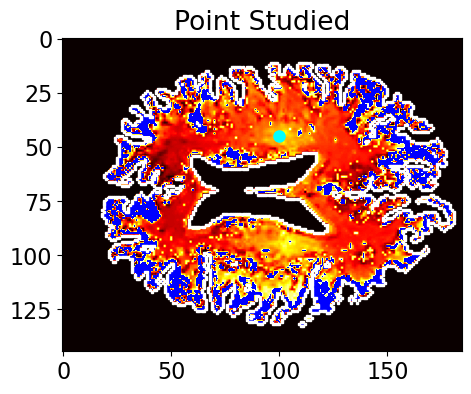

In [28]:
point_y = 45
point_x = 100

fig, ax = plt.subplots(1,1,figsize=(5,6),tight_layout=True)
plt.rc('font', size  = 16)

iter_oi = 0

MWF_cb_map = plt.get_cmap('hot', 128)
# stack_white = np.vstack(((1,0,0,0),MWF_cb_map(np.linspace(0,1,128))))
# MWF_cb_map = colors.ListedColormap(stack_white, name = 'MWF_cb_map')
MWF_cb_map.set_extremes(over = 'blue')
extend_opt = "max" #min, max, both, neither
upper_bound = 0.4


outline_indices = d1_outline_indices
data = d1_p_est_mat
BIC_region = d1_strux_mat[1][iter_oi,:,:]

# fig.suptitle('Myelin Water Fraction (MWF) Maps' + '\nNoise Realization: '+ str(iter_oi+1) + ' :: SNR = ' + str(np.round(SNR_array[iter_oi],2)))
imref = ax.imshow(data[0][:,:,0], cmap = MWF_cb_map, vmin = 0, vmax = upper_bound)
ax.plot(point_x,point_y, color = 'cyan', marker = 'o', markersize = 8, ls = '')

# ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax.plot(outline_indices[1],outline_indices[0], color = 'w', marker = 's', ls = '', markersize = 1.5)
ax.set_title('Point Studied')


print(f'MWF Estimate of Standard Reference for voxel X = {point_x} and Y = {point_y}')
print(f'c1 = {data[0][point_y,point_x,0]:.2f}')
print(f'-------------------------------------')
print(f"{'Iteration':<11}::{'Nonreg Estimate':^20}::{'GCV Estimate':^20}::{'Nonreg Bias':^20}::{'GCV Bias':^20}")
for iter in range(d1_strux_mat[1].shape[0]):
    print(f'{iter+1:<11}::{data[1][iter,point_y,point_x,0]:^20.2f}::{data[2][iter,point_y,point_x,0]:^20.2f}::{data[1][iter,point_y,point_x,0]-data[0][point_y,point_x,0]:^20.2f}::{data[2][iter,point_y,point_x,0]-data[0][point_y,point_x,0]:^20.2f}')
print(f'-------------------------------------')
print(f"{'Nonreg Variance':^20}::{'GCV Variance':^20}::{'Change in STD':^20}")
val_1 = np.var(data[1][:,point_y,point_x,0])
val_2 = np.var(data[2][:,point_y,point_x,0])
print(f'{val_1:^20.2e}::{val_2:^20.2e}::{val_1**(1/2) - val_2**(1/2):^20.2e}')
print(f"{'Nonreg Square Bias':^20}::{'GCV Square Bias':^20}::{'Change in |Bias|':^20}")
val_1 = np.mean(data[1][:,point_y,point_x,0]-data[0][point_y,point_x,0])**2
val_2 = np.mean(data[2][:,point_y,point_x,0]-data[0][point_y,point_x,0])**2
print(f'{val_1:^20.2e}::{val_2:^20.2e}::{val_1**(1/2) - val_2**(1/2):^20.2e}')
print(f"{'Nonreg MSE':^20}::{'GCV MSE':^20}::{'Change in RMSE':^20}")
val_1 = np.var(data[1][:,point_y,point_x,0])+np.mean(data[1][:,point_y,point_x,0]-data[0][point_y,point_x,0])**2
val_2 = np.var(data[2][:,point_y,point_x,0])+np.mean(data[2][:,point_y,point_x,0]-data[0][point_y,point_x,0])**2
print(f'{val_1:^20.2e}::{val_2:^20.2e}::{val_1**(1/2) - val_2**(1/2):^20.2e}')